In [1]:
import sys
sys.path.append('../')
sys.path.insert(0,'/home/abel/Documents/Projects/BioMath/EPFL/ATDS')

from xppcall import xpprun, read_pars_values_from_file
from scipy import *
from scipy.sparse import csr_matrix, lil_matrix
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pickle
import subprocess

import conley_functions as cf

In [10]:
path_to_ode = '/home/abel/Downloads/xppaut8.0ubuntu/ode/'

#RCs
xlo=0;xhi=74;ylo=0;yhi=52
grid=[]
delta = 4.
for i in range(int((xhi-xlo)/delta)):
    for j in range(int((yhi-ylo)/delta)):
        gc=(xlo+i*delta, ylo+j*delta)
        grid.append(gc)
        
time = 5000
data = np.array([[0,0]])
data_length_list = []
for gc in grid:
    npa, vn = xpprun(path_to_ode+'leslie.ode', inits={'x':gc[0],'y':gc[1]}, parameters={'total':time}, clean_after=True)
    data = np.append(data, npa[:,1:], axis=0)  
    data_length_list.append(npa.shape[0])

In [11]:
# np.savetxt("lesliedata.txt", data, delimiter=',')
# np.savetxt("leisliedata_length_list.txt", data_length_list, delimiter=',')
# data = np.loadtxt("lesliedata.txt", delimiter=',')
# data_length_list = np.loadtxt("leisliedata_length_list.txt", delimiter=',')

In [16]:
delta = .1
cds = cf.Combinatorial_Dynamical_System(delta)
cds.initialise_with_data(data, data_length_list)

In [17]:
#get recurrent components
cubes = cds.cubes
RCs = cds.get_recurrent_components()
len(RCs)

3

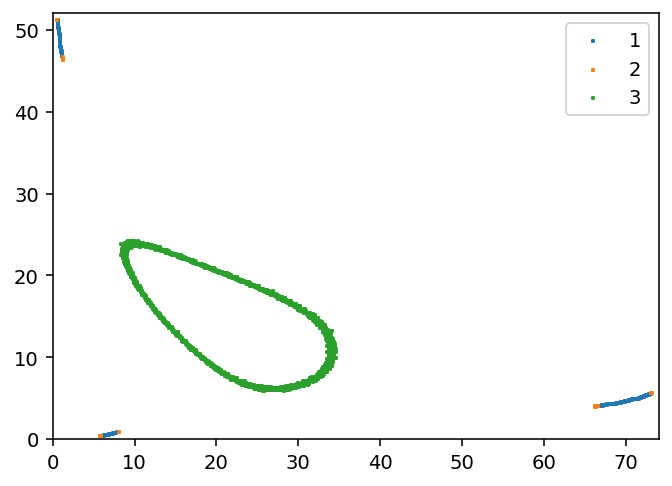

In [38]:
fig, ax = plt.subplots(dpi=141)
ax.set_xlim(xlo, xhi)
ax.set_ylim(xlo, yhi)

ax.set_aspect(1)
fig.canvas.draw()
s = max(1,((ax.get_window_extent().width  / (xhi-xlo+1.) * delta*72./fig.dpi) ** 2))  

for i in range(len(RCs)):
    plt.scatter(np.array(cubes)[RCs[i]][:,0], np.array(cubes)[RCs[i]][:,1], s=s, marker='s', label=i+1)
plt.legend()
plt.show()

In [19]:
# H = cds.maximal_closed_subgraph()
# cds.G = H

In [20]:
RPcubes = {}

for i in range(len(RCs)):
    RPcubes[i] = []
    print("Component", i+1)
    RPcubes[i].append(cds.convert_indices_to_cubes(RCs[i]))
    
    # Betti numbers of recurrent components
#     print(cf.get_bettiNumbers_of_cubicalset(Rcubes[i], cds.delta))
    
    #Get (isolated) neighbourhood (candidate) around recurrent set
    N = RPcubes[i][0]
    N_ind = cds.convert_cubes_to_indices(N)
    S_ind = cds.invariantPart(N_ind)
    S_cubes = cds.convert_indices_to_cubes(S_ind)
    M = cds.cubical_wrap(S_cubes).intersection(cds.convert_indices_to_cubes(list(cds.G.nodes())))
    for mstep in range(10):
        M = cds.cubical_wrap(M).intersection(cds.convert_indices_to_cubes(list(cds.G.nodes())))
    
    #calculate index pair
    try:
        P1, P0, Pbar1, Pbar0 = cds.index_pair(M)
    
        P1cubes = cds.convert_indices_to_cubes(P1)
        P0cubes = cds.convert_indices_to_cubes(P0)
        RPcubes[i].append(P1cubes)
        RPcubes[i].append(P0cubes)
    
        #write index pairs to file for Conley index calcualtion with CHomP
        p1cubes = cds.convert_to_invertal_representation(P1cubes)
        filetxt= cf.convert_to_chomp_format(p1cubes, delta)
        with open('leslie_rc%s_p1.cub'%(i+1), 'w') as f:
            f.writelines(filetxt)

        if P0 != set():
            p0cubes = cds.convert_to_invertal_representation(P0cubes)
            filetxt= cf.convert_to_chomp_format(p0cubes, delta)
            with open('leslie_rc%s_p0.cub'%(i+1), 'w') as f:
                f.writelines(filetxt)
        else:
            0
#             print("P0 is empty")
        
        P1graph = nx.subgraph(cds.G, P1)
        cubefile, mapfile = cf.write_mapandcubes(P1graph, cds.delta, cds)
        with open('rc%s_P1_map.map'%(i+1), 'w') as f:
            f.writelines(mapfile)

        with open('rc%s_P1_cubes.cub'%(i+1), 'w') as f:
            f.writelines(cubefile)
            
        P0graph = nx.subgraph(cds.G, P0)
        cubefile, mapfile = cf.write_mapandcubes(P0graph, cds.delta, cds)
        with open('rc%s_P0_map.map'%(i+1), 'w') as f:
            f.writelines(mapfile)
        with open('rc%s_P0_cubes.cub'%(i+1), 'w') as f:
            f.writelines(cubefile)
            
        proc = subprocess.Popen(['homcubes','rc%s_P1_cubes.cub'%(i+1), 'rc%s_P0_cubes.cub'%(i+1)],stdout=subprocess.PIPE)
        linenum = 0
        while True:
            line = proc.stdout.readline()
            if not line:
                break
            if line.rstrip().decode('UTF-8')[0:2] == 'H_':
                print("           "+line.rstrip().decode('UTF-8'))
            linenum+=1
            
    except Exception as e:
#         print("E")
        print(e)

Component 1
           H_0 = Z^3
Component 2
too many values to unpack (expected 4)
Component 3
           H_0 = Z^12
           H_1 = Z^57
